In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
from torchsummary import summary
import imageio
import pandas as pd

In [2]:
# Set random seed for reproducibility
manualSeed = 878
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  878


In [3]:
class MNISTM(Dataset):
    def __init__(self, img_path, transform=None) :
        self.img_path = img_path
        self.transform = transform

        self.labels = pd.read_csv(os.path.join(os.path.dirname(img_path),'train.csv'),index_col='image_name')
        
        self.filepaths = []
        fns = glob.glob(os.path.join(img_path+'/*.png'))
        for i in fns:
            self.filepaths.append(i)
        self.len = len(self.filepaths)
    
    def __getitem__(self, index) :
        fn = self.filepaths[index]
        img = Image.open(fn)
        if self.transform is not None:
            img = self.transform(img)
        
        return img,self.labels['label'][os.path.basename(fn)]
    
    def __len__(self):
        return self.len

In [4]:
trainSet = MNISTM(img_path = 'hw2_data/digits/mnistm/train',transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
))

In [5]:
type(trainSet[0][1])

numpy.int64

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
# lr = 0.0002
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#batch_size
batchsize = 128

# Number of classifier amount
ncls = 10

In [8]:
trainLoader = DataLoader(trainSet, batch_size = batchsize, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz+ncls, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 2, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(56, 28, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(28, 3, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
from torchsummary import summary
n = torch.randn(nz+ncls, 1, 1, device=device)
summary(netG, n.shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 224, 4, 4]         394,240
       BatchNorm2d-2            [-1, 224, 4, 4]             448
              ReLU-3            [-1, 224, 4, 4]               0
   ConvTranspose2d-4            [-1, 112, 8, 8]         401,408
       BatchNorm2d-5            [-1, 112, 8, 8]             224
              ReLU-6            [-1, 112, 8, 8]               0
   ConvTranspose2d-7           [-1, 56, 16, 16]         100,352
       BatchNorm2d-8           [-1, 56, 16, 16]             112
              ReLU-9           [-1, 56, 16, 16]               0
  ConvTranspose2d-10           [-1, 28, 15, 15]           6,272
      BatchNorm2d-11           [-1, 28, 15, 15]              56
             ReLU-12           [-1, 28, 15, 15]               0
  ConvTranspose2d-13            [-1, 3, 28, 28]             336
             Tanh-14            [-1, 3,

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
        )
        self.realfake = nn.Sequential(
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.cls = nn.Sequential(
            nn.Conv2d(ndf * 4, ncls, 4, 1, 0, bias=False),
            nn.Softmax()
        )

    def forward(self, input):
        input = self.main(input)
        rf_ = self.realfake(input)
        cls_ = self.cls(input)
        return rf_, cls_

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (realfake): Sequential(
    (0): Conv2d(112, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (cls): Sequential(
    (0): Conv2d(112, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Softmax(dim=None)
  )
)


In [53]:
from torchsummary import summary

summary(netD, (3,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 14, 14]           1,344
         LeakyReLU-2           [-1, 28, 14, 14]               0
            Conv2d-3             [-1, 56, 7, 7]          25,088
       BatchNorm2d-4             [-1, 56, 7, 7]             112
         LeakyReLU-5             [-1, 56, 7, 7]               0
            Conv2d-6            [-1, 112, 4, 4]          56,448
       BatchNorm2d-7            [-1, 112, 4, 4]             224
         LeakyReLU-8            [-1, 112, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           1,792
          Sigmoid-10              [-1, 1, 1, 1]               0
           Conv2d-11             [-1, 10, 1, 1]          17,920
          Softmax-12             [-1, 10, 1, 1]               0
Total params: 102,928
Trainable params: 102,928
Non-trainable params: 0
-------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [54]:
# Initialize BCELoss function
criterion = nn.BCELoss()
criterion_classifier = nn.CrossEntropyLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [55]:
import digit_classifier
net_eval = digit_classifier.Classifier()
net_eval.to(device)
path = "Classifier.pth"
digit_classifier.load_checkpoint(path, net_eval)
summary(net_eval, (3,28,28))

model loaded from Classifier.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             456
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 128]          32,896
            Linear-6                   [-1, 64]           8,256
            Linear-7                   [-1, 10]             650
Total params: 44,674
Trainable params: 44,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [56]:
import matplotlib.pyplot as plt

def output_fake_image_and_evaluate(model,epoch,each_image_amout,outpath,device,save=True):
    #images.shape : (amount_of_images, 3, 28, 28), type:numpy
    
    correct = 0
    each_imgs = torch.empty((0,3,ngf,ngf),device=device)
    for cls in range(ncls):
        random.seed(manualSeed)
        torch.manual_seed(manualSeed)
        cls = torch.full((each_image_amout,),cls,device=device)
        # print(cls)

        noise = torch.randn(each_image_amout, nz, 1, 1, device=device)
        # normalize
        onehot_label = torch.eye(ncls,device=device)[cls].view(-1, ncls, 1, 1)
        noise = torch.cat((noise,onehot_label),dim=1)
        
        images = model(noise)
        out = net_eval(images)
        pred = out.max(1)[1]
        correct += pred.eq(cls.view_as(pred)).sum()
        each_imgs = torch.cat((each_imgs,images),dim=0)

    print('Accuracy: {}/{} ({:.0f}%)'.format(correct,each_image_amout*ncls,100.*correct/each_image_amout/ncls))
    
    each_imgs = each_imgs.cpu().detach().numpy()
    # output amt = ncls * each_image_amout images

    # transpose shape to output image(amt, 3, 28, 28) ->(amt, 28, 28, 3)
    imgs_for_output = np.transpose(each_imgs,(0,2,3,1))
    
    # ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    # HTML(ani.to_jshtml())


    imgs_for_output = ((imgs_for_output+1)*127.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    reg = 1
    for i,ele in enumerate(imgs_for_output):
        #shape i = (28,28,3)
        imageio.imsave(os.path.join(outpath,"{}_{:0>3d}.png".format(i//each_image_amout,i%each_image_amout+1)),
                        ele.astype(np.uint8))
        if(i%each_image_amout<10):
            plt.subplot(10,10,reg)
            plt.axis('off')
            plt.imshow(ele, interpolation='nearest')
            reg+=1
    plt.show()
    if(100.*correct/each_image_amout/ncls>=70 and save):
        torch.save(model,'.pth2/p2_epoch_{}_acc_{:.0f}.pth'.format(epoch,100.*correct/each_image_amout/ncls))

    # torch.save(model,'.pth2/p2_epoch_{}_acc_{:.0f}.pth'.format(epoch,100.*correct/each_image_amout/ncls))

Accuracy: 900/1000 (90%)


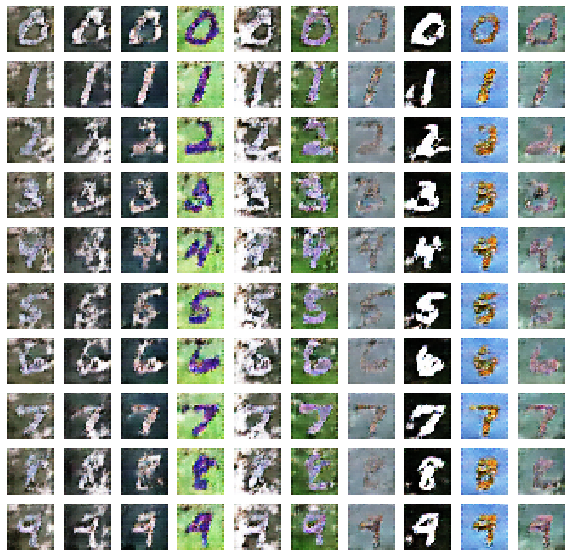

In [ ]:
m = torch.load('.pth2_perfect/p2_epoch_13_acc_90.pth')
m.to(device)
output_fake_image_and_evaluate(m,0,100,'p2_fin_out',device,save=False)

In [61]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    imgs_for_is = np.empty((0,3,64,64))
    # For each batch in the dataloader
    for i, data in enumerate(trainLoader, 0):
        # for testing 
        if(i==10):break
        # print(type(data[1]))
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu, cls_cpu = data
        print(cls_cpu)
        real_cpu = real_cpu.to(device)
        cls_cpu = cls_cpu.to(device)
        b_size = real_cpu.size(0)

        label = torch.full((b_size,), real_label, dtype=torch.float,device=device)
        # label_cls = torch.fill_((b_size,), real_cls_cpu, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu)[0].view(-1)
        output_cls = netD(real_cpu)[1].view(-1,ncls)
        # print(output_cls.shape)
        # output_cls = torch.reshape(output_cls, (b_size, ncls))
        label_cls = cls_cpu
        # print(output_cls.shape, cls_cpu.shape)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label) + criterion_classifier(output_cls, cls_cpu)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        D_x_cls = output_cls.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # print(noise.shape)
        # onehot_label = (torch.eye(ncls,device=device)[cls_cpu]*noise.max()).view(-1, ncls, 1, 1)
        onehot_label = torch.eye(ncls,device=device)[cls_cpu].view(-1, ncls, 1, 1)
        # print(onehot_label)
        # print(noise.shape, onehot_label.shape)
        # print(onehot_label.shape)

        noise = torch.cat((noise,onehot_label),dim=1)

        # State noise shape : (batch_size, 110, 1, 1)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach())[0].view(-1)
        output_cls = netD(fake.detach())[1].view(-1,ncls)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label) + criterion_classifier(output_cls, cls_cpu)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        D_G_z1_cls = output_cls.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)[0].view(-1)
        output_cls = netD(fake)[1].view(-1,ncls)
        # Calculate G's loss based on this output
        errG = criterion(output, label) + criterion_classifier(output_cls, cls_cpu)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainLoader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    output_fake_image_and_evaluate(netG,epoch,100,"hw2_data\out2",device)
    
    

<class 'numpy.int64'>
Starting Training Loop...
tensor([6, 6, 7, 3, 6, 9, 4, 4, 4, 3, 2, 6, 1, 9, 0, 4, 1, 0, 7, 3, 2, 9, 7, 6,
        4, 4, 6, 3, 6, 4, 4, 4, 8, 8, 5, 6, 8, 1, 8, 7, 8, 9, 5, 0, 8, 1, 5, 7,
        3, 1, 2, 7, 0, 0, 4, 0, 9, 5, 1, 3, 1, 7, 8, 3, 0, 6, 2, 0, 9, 3, 1, 5,
        3, 8, 9, 6, 2, 7, 4, 6, 3, 6, 3, 5, 0, 3, 0, 6, 4, 9, 1, 8, 0, 6, 3, 2,
        3, 6, 0, 0, 0, 4, 5, 7, 5, 1, 2, 6, 6, 5, 0, 6, 0, 7, 3, 9, 5, 3, 9, 1,
        3, 0, 4, 3, 1, 3, 7, 8])
[0/100][0/469]	Loss_D: 5.8834	Loss_G: 3.2036	D(x): 0.5731	D(G(z)): 0.5074 / 0.4103
tensor([1, 9, 2, 5, 0, 2, 7, 2, 6, 0, 7, 8, 2, 3, 5, 3, 2, 3, 4, 2, 1, 8, 4, 7,
        9, 5, 2, 1, 7, 3, 2, 3, 9, 4, 0, 0, 2, 4, 3, 9, 9, 3, 9, 1, 9, 5, 1, 2,
        2, 0, 3, 5, 5, 9, 5, 9, 5, 4, 6, 4, 0, 4, 0, 2, 1, 4, 0, 1, 7, 1, 9, 0,
        9, 0, 9, 0, 7, 3, 1, 8, 6, 8, 2, 1, 2, 9, 5, 0, 6, 5, 4, 1, 3, 5, 4, 2,
        2, 6, 3, 9, 2, 7, 0, 5, 6, 3, 3, 2, 5, 2, 7, 1, 3, 0, 1, 4, 8, 9, 6, 6,
        3, 2, 7, 8, 7, 1, 4, 1])
ten

TypeError: int() argument must be a string, a bytes-like object or a number, not 'PngImageFile'